<h1 align="center">Laboratorio 3</h1>

## Información

**Integrantes:**

| Name              | Institution ID | GitHub User |
| ----------------- | -------------- | ----------- |
| Josué Say         | 22801          | JosueSay    |
| Carlos Valladares | 221164         | vgcarlol    |

- [Repositorio](https://github.com/JosueSay/intro-to-computer-vision/tree/main/labs/lab2)

## Preparación de entorno

In [ ]:
# %pip install -r requirements.txt
# jupyter notebook .\lab3.ipynb

## Librerías y Configuración

In [24]:
import cv2, math, os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

## Task 1

Usted deberá demostrar comprensión teórica del criterio de Harris sin usar librerías. Para ello considere lo siguiente.

Se te da la siguiente Matriz del Segundo Momento (Tensor de Estructura) $M$ calculada en un píxel específico $(u,v)$ de una imagen:

$$
M =
\begin{bmatrix}
120 & 5 \\
5 & 115
\end{bmatrix}
$$

Y una segunda matriz $M'$ para otro píxel diferente:

$$
M' =
\begin{bmatrix}
200 & 10 \\
10 & 1
\end{bmatrix}
$$

Con esta información haga lo siguiente:

### Constantes

In [9]:
m = np.array([
    [120, 5],
    [5, 115]
], dtype=float)

m_prime = np.array([
    [200, 10],
    [10, 1]
], dtype=float)

k_value = 0.04

### Inciso 1

Calcule manualmente (muestra tu procedimiento) los eigenvalores $(\lambda_1, \lambda_2)$ para ambas matrices.

In [ ]:
def computeEigenvalues2x2(
    matrix_2x2,
    matrix_name="M",
    show_logs=True,
    show_table=True
):
    """
    Calcula eigenvalores de una matriz 2x2 simétrica
    usando el polinomio característico.
    """

    # Extraer elementos
    a = float(matrix_2x2[0, 0])
    b = float(matrix_2x2[0, 1])
    d = float(matrix_2x2[1, 1])

    # Calculos base
    trace_val = a + d
    det_val = a * d - b * b

    # Discriminante
    discriminant = trace_val * trace_val - 4 * det_val
    sqrt_discriminant = np.sqrt(discriminant)

    # Eigenvalores
    lambda_1 = (trace_val + sqrt_discriminant) / 2
    lambda_2 = (trace_val - sqrt_discriminant) / 2

    if show_logs:
        print("\n==============================")
        print(f"Procesando matriz {matrix_name}")
        print("================================")
        print("Matriz de entrada:")
        print(matrix_2x2)

        print("\nPaso 1: Extraer componentes")
        print(f"a = {a}")
        print(f"b = {b}")
        print(f"d = {d}")

        print("\nPaso 2: Calcular traza y determinante")
        print(f"trace = a + d = {trace_val}")
        print(f"det = a*d - b*b = {det_val}")

        print("\nPaso 3: Calcular discriminante")
        print(f"discriminant = trace^2 - 4*det = {discriminant}")
        print(f"sqrt(discriminant) = {sqrt_discriminant}")

        print("\nPaso 4: Calcular eigenvalores")
        print(f"lambda_1 = (trace + sqrt_disc) / 2 = {lambda_1}")
        print(f"lambda_2 = (trace - sqrt_disc) / 2 = {lambda_2}")

    if show_table:
        table = [
            ["a (I_x^2)", a],
            ["b (I_x I_y)", b],
            ["d (I_y^2)", d],
            ["trace", trace_val],
            ["det", det_val],
            ["discriminant", discriminant],
            ["sqrt_discriminant", sqrt_discriminant],
            ["lambda_1", lambda_1],
            ["lambda_2", lambda_2],
        ]

        print("\nResumen numerico:")
        print(tabulate(table, headers=["Variable", "Valor"], tablefmt="grid"))

    return {
        "a": a,
        "b": b,
        "d": d,
        "trace": trace_val,
        "det": det_val,
        "discriminant": discriminant,
        "sqrt_discriminant": sqrt_discriminant,
        "lambda_1": lambda_1,
        "lambda_2": lambda_2,
    }

In [6]:
result_m = computeEigenvalues2x2(
    m,
    matrix_name="M",
    show_logs=True,
    show_table=False
)


Procesando matriz M
Matriz de entrada:
[[120.   5.]
 [  5. 115.]]

Paso 1: Extraer componentes
a = 120.0
b = 5.0
d = 115.0

Paso 2: Calcular traza y determinante
trace = a + d = 235.0
det = a*d - b*b = 13775.0

Paso 3: Calcular discriminante
discriminant = trace^2 - 4*det = 125.0
sqrt(discriminant) = 11.180339887498949

Paso 4: Calcular eigenvalores
lambda_1 = (trace + sqrt_disc) / 2 = 123.09016994374947
lambda_2 = (trace - sqrt_disc) / 2 = 111.90983005625053


In [8]:
result_m_prime = computeEigenvalues2x2(
    m_prime,
    matrix_name="M_prime",
    show_logs=False,
    show_table=True
)


Resumen numerico:
+-------------------+-------------+
| Variable          |       Valor |
+===================+=============+
| a (I_x^2)         |   200       |
+-------------------+-------------+
| b (I_x I_y)       |    10       |
+-------------------+-------------+
| d (I_y^2)         |     1       |
+-------------------+-------------+
| trace             |   201       |
+-------------------+-------------+
| det               |   100       |
+-------------------+-------------+
| discriminant      | 40001       |
+-------------------+-------------+
| sqrt_discriminant |   200.002   |
+-------------------+-------------+
| lambda_1          |   200.501   |
+-------------------+-------------+
| lambda_2          |     0.49875 |
+-------------------+-------------+


### Inciso 2

Calcule la Respuesta de Harris $(R)$ para ambas matrices usando la fórmula vista en clase. Asuma $k = 0.04$.

In [13]:
def computeHarrisResponse2x2(
    matrix_2x2,
    k_value=0.04,
    matrix_name="M",
    show_logs=True,
    show_table=True
):
    """
    Calcula la respuesta de Harris:
    R = det - k * (trace * trace)
    para matriz 2x2 simetrica [[a,b],[b,d]].
    """

    # Extraer componentes
    a = float(matrix_2x2[0, 0])
    b = float(matrix_2x2[0, 1])
    d = float(matrix_2x2[1, 1])

    # Calculos
    trace_val = a + d
    det_val = a * d - b * b
    trace_squared = trace_val * trace_val
    penalty_term = k_value * trace_squared
    r_value = det_val - penalty_term

    if show_logs:
        print("\n==================================")
        print(f"Respuesta Harris para {matrix_name}")
        print("====================================")
        print("Matriz de entrada:")
        print(matrix_2x2)

        print("\nPaso 1: Extraer componentes")
        print(f"a = {a}")
        print(f"b = {b}")
        print(f"d = {d}")

        print("\nPaso 2: Calcular trace y det")
        print(f"trace = a + d = {trace_val}")
        print(f"det = a*d - b*b = {det_val}")

        print("\nPaso 3: Calcular termino de penalizacion")
        print(f"trace_squared = trace * trace = {trace_squared}")
        print(f"penalty_term = k * trace_squared = {k_value} * {trace_squared} = {penalty_term}")

        print("\nPaso 4: Calcular R")
        print(f"R = det - penalty_term = {det_val} - {penalty_term} = {r_value}")

    if show_table:
        table = [
            ["a", a],
            ["b", b],
            ["d", d],
            ["k_value", k_value],
            ["trace", trace_val],
            ["det", det_val],
            ["trace_squared", trace_squared],
            ["penalty_term", penalty_term],
            ["R", r_value],
        ]
        print("\nResumen numerico:")
        print(tabulate(table, headers=["Variable", "Valor"], tablefmt="grid"))

    return {
        "a": a,
        "b": b,
        "d": d,
        "k_value": k_value,
        "trace": trace_val,
        "det": det_val,
        "trace_squared": trace_squared,
        "penalty_term": penalty_term,
        "R": r_value,
    }

In [14]:
result_m_r = computeHarrisResponse2x2(
    m,
    k_value=k_value,
    matrix_name="M",
    show_logs=True,
    show_table=False
)


Respuesta Harris para M
Matriz de entrada:
[[120.   5.]
 [  5. 115.]]

Paso 1: Extraer componentes
a = 120.0
b = 5.0
d = 115.0

Paso 2: Calcular trace y det
trace = a + d = 235.0
det = a*d - b*b = 13775.0

Paso 3: Calcular termino de penalizacion
trace_squared = trace * trace = 55225.0
penalty_term = k * trace_squared = 0.04 * 55225.0 = 2209.0

Paso 4: Calcular R
R = det - penalty_term = 13775.0 - 2209.0 = 11566.0


In [15]:
result_m_prime_r = computeHarrisResponse2x2(
    m_prime,
    k_value=k_value,
    matrix_name="M_prime",
    show_logs=False,
    show_table=True
)


Resumen numerico:
+---------------+----------+
| Variable      |    Valor |
+===============+==========+
| a             |   200    |
+---------------+----------+
| b             |    10    |
+---------------+----------+
| d             |     1    |
+---------------+----------+
| k_value       |     0.04 |
+---------------+----------+
| trace         |   201    |
+---------------+----------+
| det           |   100    |
+---------------+----------+
| trace_squared | 40401    |
+---------------+----------+
| penalty_term  |  1616.04 |
+---------------+----------+
| R             | -1516.04 |
+---------------+----------+


### Inciso 3

Basado en tus resultados numéricos, clasifica qué representa cada píxel geométricamente: ¿Es una Esquina, un Borde o una Región Plana? Justifica tu respuesta usando las definiciones de eigenvalores vistas en clase.

**Criterio visto en clase (Harris / eigenvalores):**

- Región plana: ambos eigenvalores pequeños
- Borde: un eigenvalor grande y el otro pequeño
- Esquina: ambos eigenvalores grandes y de magnitud similar

**Pixel de la matriz M**

- Eigenvalores:
  - lambda_1 ≈ 123.09
  - lambda_2 ≈ 111.91
- Ambos eigenvalores son grandes y comparables entre sí esto indica variación significativa de intensidad en dos direcciones ortogonales y Harris fue positiva y alta (R > 0); por lo que es una **esquina**.

**Justificación:**

Según lo visto en clase, cuando ambos eigenvalores de la matriz de segundo momento son grandes, el punto presenta cambios de intensidad en todas las direcciones, lo cual caracteriza una esquina estable.



**Pixel de la matriz M'**

- Eigenvalores:
  - lambda_1 ≈ 200.50
  - lambda_2 ≈ 0.50
- Un eigenvalor es grande y el otro muy pequeño esto indica variación fuerte en una sola dirección y casi nula en la perpendicular y Harris fue negativa (R < 0); entonces es un **Borde**.

**Justificación:**

Como se explicó en clase, un borde se caracteriza porque la intensidad cambia fuertemente en una sola dirección. Esto se refleja en un eigenvalor grande y otro pequeño, y produce una respuesta de Harris negativa.


| Matriz | Eigenvalores (comportamiento) | R de Harris | Clasificación |
| ------ | ----------------------------- | ----------- | ------------- |
| M      | Ambos grandes y similares     | Positivo    | Esquina       |
| M'     | Uno grande, uno pequeño       | Negativo    | Borde         |

## Task 2

En esta parte se busca que usted implemente un sistema de correspondencia completo. Para esto debe escribir un script en Python usando OpenCV. No se provee código base, debe estructurarlo usted mismx.

Para esta parte debe crear su propia imagen a usar para esto:

- Tome dos fotografías propias de un objeto con textura (i.e. una caja de cereal, una portada de libro, un edificio)
- Foto 1: Vista frontal
- Foto 2: Vista rotada (aproximadamente $45^\circ$) y con cambio de escala (aléjese o haga zoom).  
  El cambio debe ser evidente

Con esto haga lo siguiente en su código:

### Constantes

In [17]:
imagePaths = [
    "images/libro_frontal.png",
    "images/libro_rotado_escala.png"
]

### Inciso 1

Cargue ambas imágenes en escala de grises.

In [26]:
def loadConvertImageToGray(imagePaths, gridCols=2):
    grayImages = {}

    numImages = len(imagePaths)
    gridRows = math.ceil(numImages / gridCols)

    plt.figure(figsize=(6 * gridCols, 6 * gridRows))

    for idx, imagePath in enumerate(imagePaths):
        # Validar existencia y cargar imagen
        if not os.path.exists(imagePath):
            raise FileNotFoundError(f"No se encontró la imagen: {imagePath}")

        imageColor = cv2.imread(imagePath)
        if imageColor is None:
            raise IOError(f"No se pudo cargar la imagen: {imagePath}")

        imageGray = cv2.cvtColor(imageColor, cv2.COLOR_BGR2GRAY)
        imageName = os.path.basename(imagePath)
        grayImages[imageName] = imageGray

        # grid
        plt.subplot(gridRows, gridCols, idx + 1)
        plt.imshow(imageGray, cmap="gray")
        plt.title(imageName)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return grayImages

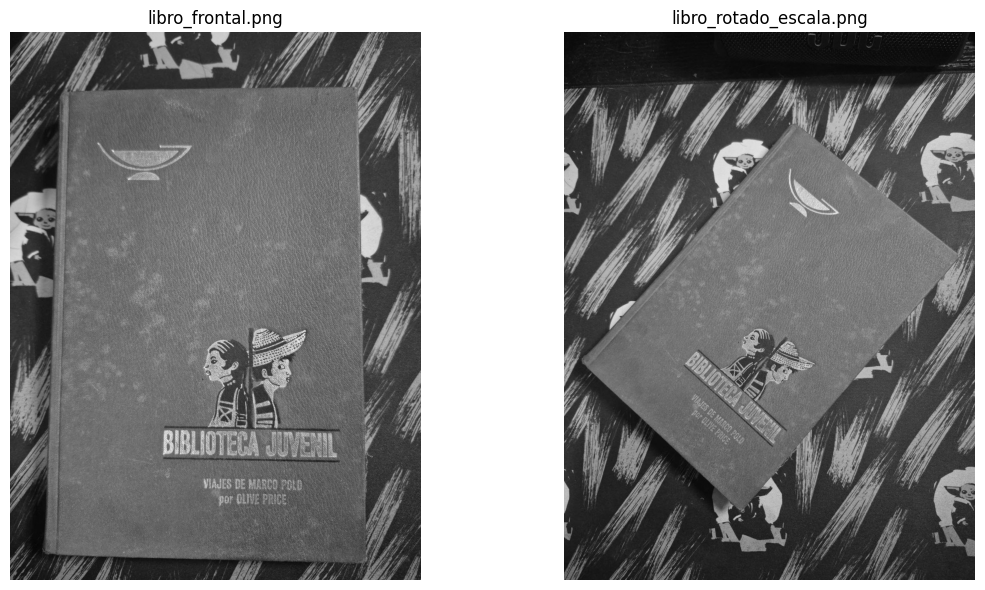

In [27]:
grayImages = loadConvertImageToGray(imagePaths)
img1Gray = grayImages["libro_frontal.png"]
img2Gray = grayImages["libro_rotado_escala.png"]

### Inciso 2

Implemente la detección y descripción usando SIFT.

In [ ]:
def detectDescribeSIFT(
    image_gray,
    image_name="image",
    show_logs=True,
    show_plot=True,
    max_keypoints_to_draw=200
):

    # detector SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)

    if show_logs:
        print("\n===========================================")
        print(f"SIFT - Deteccion y descripcion: {image_name}")
        print("=============================================")
        print(f"Dimensiones imagen: {image_gray.shape}")
        print(f"Numero de keypoints detectados: {len(keypoints)}")

        if descriptors is not None:
            print(f"Dimensiones del descriptor: {descriptors.shape}")
            print("Cada descriptor tiene 128 dimensiones (SIFT)")
        else:
            print("No se calcularon descriptores")

    if show_plot:
        # quitar keypoints para visualizacion
        keypoints_to_draw = keypoints[:max_keypoints_to_draw]

        image_with_kp = cv2.drawKeypoints(
            image_gray,
            keypoints_to_draw,
            None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        plt.figure(figsize=(8, 8))
        plt.imshow(image_with_kp, cmap="gray")
        plt.title(f"SIFT keypoints - {image_name}")
        plt.axis("off")
        plt.show()

    return keypoints, descriptors


SIFT - Deteccion y descripcion: libro_frontal
Dimensiones imagen: (1280, 960)
Numero de keypoints detectados: 5648
Dimensiones del descriptor: (5648, 128)
Cada descriptor tiene 128 dimensiones (SIFT)


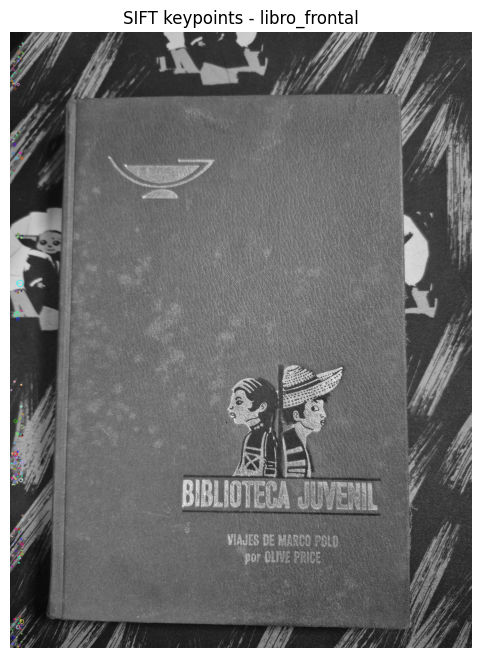


SIFT - Deteccion y descripcion: libro_rotado_escala
Dimensiones imagen: (1280, 960)
Numero de keypoints detectados: 7398
Dimensiones del descriptor: (7398, 128)
Cada descriptor tiene 128 dimensiones (SIFT)


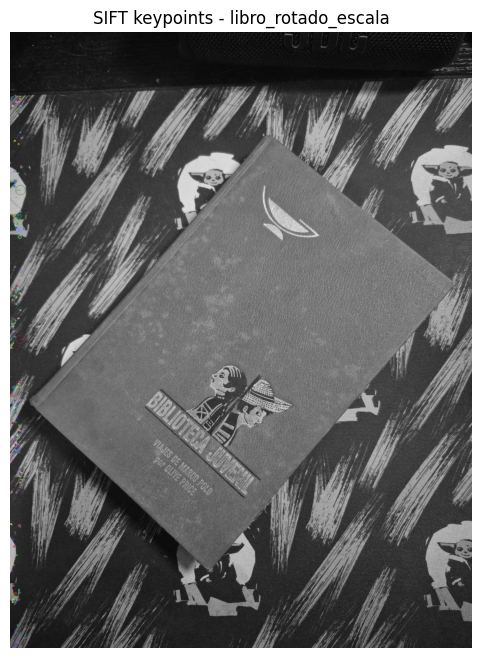

In [29]:
kp1, desc1 = detectDescribeSIFT(
    img1Gray,
    image_name="libro_frontal",
    show_logs=True,
    show_plot=True
)

kp2, desc2 = detectDescribeSIFT(
    img2Gray,
    image_name="libro_rotado_escala",
    show_logs=True,
    show_plot=True
)

### Inciso 3

Implemente la detección y descripción usando ORB.

In [30]:
def detectDescribeORB(
    image_gray,
    image_name="image",
    n_features=1000,
    show_logs=True,
    show_plot=True,
    max_keypoints_to_draw=200
):
    # detector ORB
    orb = cv2.ORB_create(nfeatures=n_features)
    keypoints, descriptors = orb.detectAndCompute(image_gray, None)

    if show_logs:
        print("\n==========================================")
        print(f"ORB - Deteccion y descripcion: {image_name}")
        print("============================================")
        print(f"Dimensiones imagen: {image_gray.shape}")
        print(f"Numero de keypoints detectados: {len(keypoints)}")

        if descriptors is not None:
            print(f"Dimensiones del descriptor: {descriptors.shape}")
            print("Descriptor binario (ORB, BRIEF orientado)")
        else:
            print("No se calcularon descriptores")

    if show_plot:
        keypoints_to_draw = keypoints[:max_keypoints_to_draw]

        image_with_kp = cv2.drawKeypoints(
            image_gray,
            keypoints_to_draw,
            None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        plt.figure(figsize=(8, 8))
        plt.imshow(image_with_kp, cmap="gray")
        plt.title(f"ORB keypoints - {image_name}")
        plt.axis("off")
        plt.show()

    return keypoints, descriptors



ORB - Deteccion y descripcion: libro_frontal
Dimensiones imagen: (1280, 960)
Numero de keypoints detectados: 1000
Dimensiones del descriptor: (1000, 32)
Descriptor binario (ORB, BRIEF orientado)


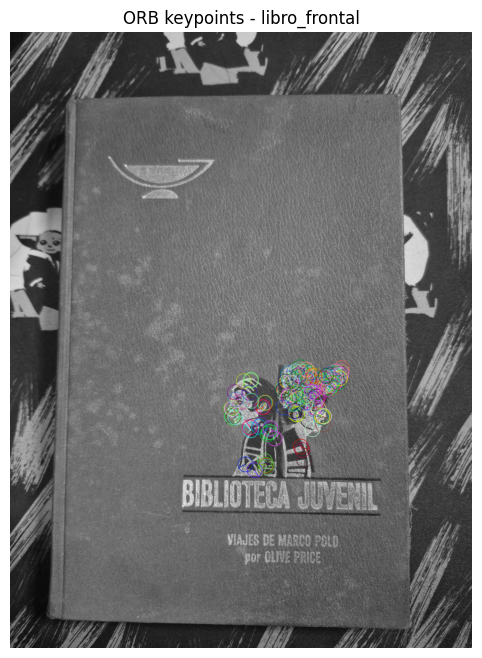


ORB - Deteccion y descripcion: libro_rotado_escala
Dimensiones imagen: (1280, 960)
Numero de keypoints detectados: 1000
Dimensiones del descriptor: (1000, 32)
Descriptor binario (ORB, BRIEF orientado)


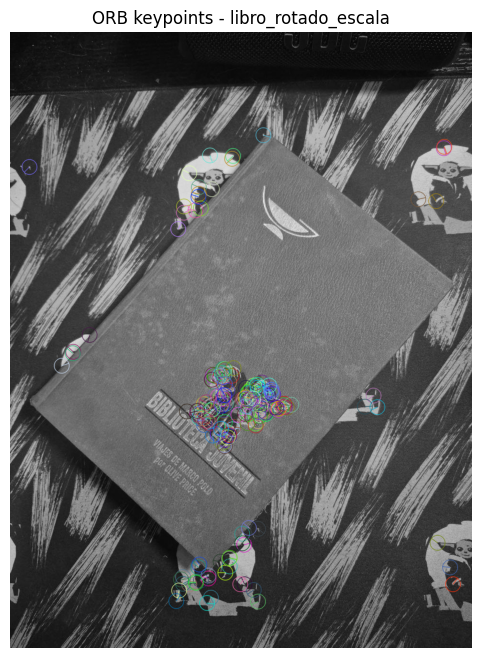

In [31]:
kp1_orb, desc1_orb = detectDescribeORB(
    img1Gray,
    image_name="libro_frontal",
    n_features=1000,
    show_logs=True,
    show_plot=True
)

kp2_orb, desc2_orb = detectDescribeORB(
    img2Gray,
    image_name="libro_rotado_escala",
    n_features=1000,
    show_logs=True,
    show_plot=True
)

### Inciso 4

Realice la parte de Matching:

In [36]:
def matchDescriptorsKNN(
    descriptors_1,
    descriptors_2,
    method="SIFT",
    show_logs=True
):
    # matching KNN (k=2) 

    if method == "SIFT":
        norm_type = cv2.NORM_L2
    elif method == "ORB":
        norm_type = cv2.NORM_HAMMING
    else:
        raise ValueError("Metodo no soportado")

    matcher = cv2.BFMatcher(norm_type, crossCheck=False)

    knn_matches = matcher.knnMatch(descriptors_1, descriptors_2, k=2)

    if show_logs:
        print("\n==================================")
        print(f"Matching KNN sin filtrar ({method})")
        print("====================================")
        print(f"Total matches KNN: {len(knn_matches)}")

    return knn_matches

#### Inciso a

Para SIFT: Utilice BFMatcher con norma $L_2$ (Euclidiana)  

In [37]:
knn_matches_sift = matchDescriptorsKNN(
    descriptors_1=desc1,
    descriptors_2=desc2,
    method="SIFT",
    show_logs=True
)


Matching KNN sin filtrar (SIFT)
Total matches KNN: 5648


#### Inciso b

Para ORB: Utilice BFMatcher con norma de Hamming

In [38]:
knn_matches_orb = matchDescriptorsKNN(
    descriptors_1=desc1_orb,
    descriptors_2=desc2_orb,
    method="ORB",
    show_logs=True
)


Matching KNN sin filtrar (ORB)
Total matches KNN: 1000


### Inciso 5

Implemente Lowe’s Ratio Test para ambos algoritmos  

In [ ]:
def applyLowesRatioTest(
    knn_matches,
    ratio_threshold=0.75,
    show_logs=True
):

    good_matches = []

    for m, n in knn_matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    if show_logs:
        print("\n=============")
        print("Lowe Ratio Test")
        print("===============")
        print(f"Total matches antes del filtrado: {len(knn_matches)}")
        print(f"Matches despues del filtrado: {len(good_matches)}")
        print(f"Ratio threshold usado: {ratio_threshold}")

    return good_matches

#### Inciso a

Debe filtrar los matches donde la distancia del mejor vecino sea mayor a $0.75 \times$ la distancia del segundo mejor vecino

In [40]:
good_matches_sift = applyLowesRatioTest(
    knn_matches_sift,
    ratio_threshold=0.75,
    show_logs=True
)


Lowe Ratio Test
Total matches antes del filtrado: 5648
Matches despues del filtrado: 796
Ratio threshold usado: 0.75


In [41]:
good_matches_orb = applyLowesRatioTest(
    knn_matches_orb,
    ratio_threshold=0.75,
    show_logs=True
)


Lowe Ratio Test
Total matches antes del filtrado: 1000
Matches despues del filtrado: 197
Ratio threshold usado: 0.75


### Inciso 6

Genere una imagen final donde se dibujen las líneas de correspondencia solamente de los “buenos matches” (inliers) tras el filtro.

In [42]:
def drawGoodMatches(
    image_1_gray,
    keypoints_1,
    image_2_gray,
    keypoints_2,
    good_matches,
    title="Good Matches",
    max_matches_to_draw=50
):
    matches_to_draw = good_matches[:max_matches_to_draw]

    matched_image = cv2.drawMatches(
        image_1_gray,
        keypoints_1,
        image_2_gray,
        keypoints_2,
        matches_to_draw,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(matched_image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

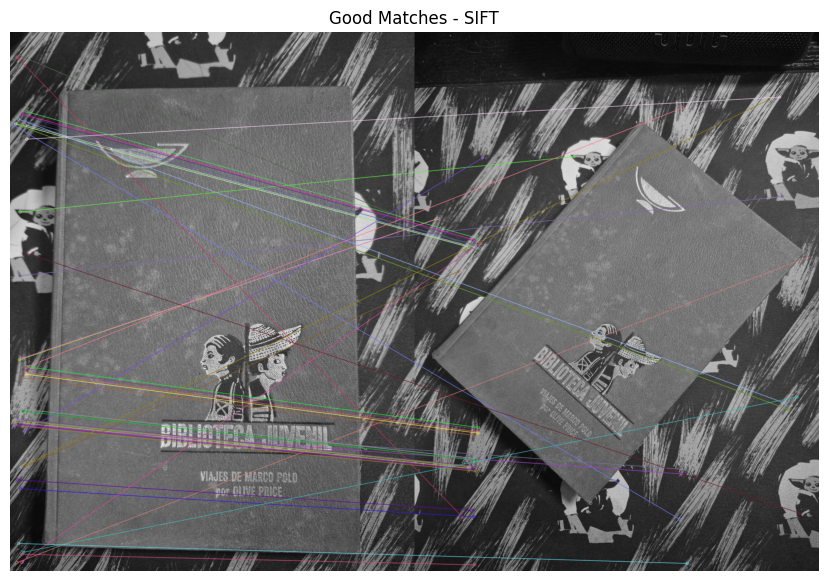

In [43]:
drawGoodMatches(
    image_1_gray=img1Gray,
    keypoints_1=kp1,
    image_2_gray=img2Gray,
    keypoints_2=kp2,
    good_matches=good_matches_sift,
    title="Good Matches - SIFT"
)

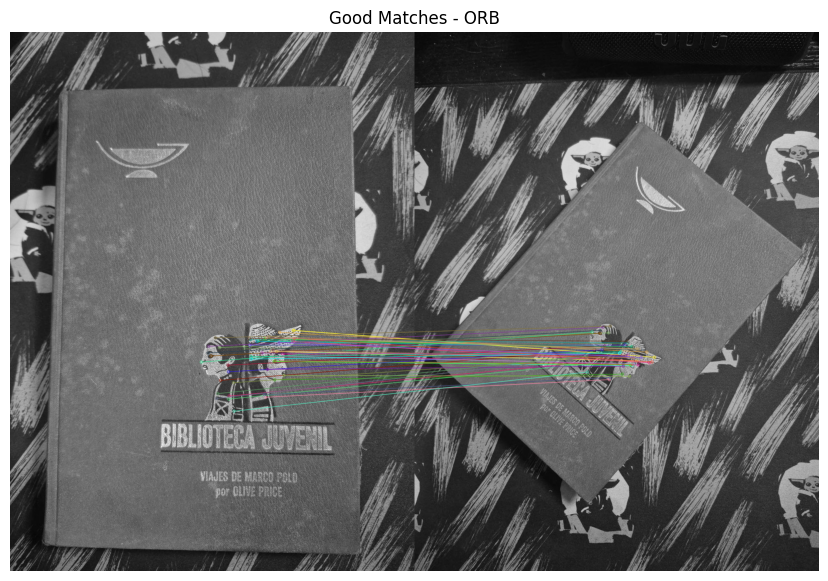

In [44]:
drawGoodMatches(
    image_1_gray=img1Gray,
    keypoints_1=kp1_orb,
    image_2_gray=img2Gray,
    keypoints_2=kp2_orb,
    good_matches=good_matches_orb,
    title="Good Matches - ORB"
)

## Task 3

En esta parte lo que se busca es evaluar trade-offs y tomar decisiones técnicas basadas en datos. Por ello es importante considerar que la implementación por sí sola no nos sirve para saber cuánto “cuesta” ejecutarla. Debe modificar un poco su código del Task 2 (en su entrega deben mostrar el código de la parte 2 solamente y luego copie y pegue en otra sección el código y en este haga los cambios necesarios) para medir el tiempo.


Imagine que ha sido contratadx como Ingenierx de Visión Computacional en una startup de drones autónomos. La empresa tiene dos productos en desarrollo y usted debe decidir qué algoritmo implementar en cada uno:

1. Producto A (Drone de Carreras): Vuela a $80\ \text{km/h}$ en interiores. Necesita estimar su posición (Odometría Visual) a $60\ \text{FPS}$ mínimo. La calidad de la imagen es baja y borrosa.

2. Producto B (Drone de Inspección de Grietas): Vuela estático frente a presas hidroeléctricas. Toma fotos de altísima resolución $(4K)$ para crear un mapa detallado (Stitching). El tiempo de procesamiento no es crítico, pero la precisión del emparejamiento debe ser milimétrica.

Su misión es medir y justificar qué algoritmo usará para cada caso basándose en datos empíricos.

Con esto en mente, realice lo siguiente:


1. Usando librerías como `time` o `timeit` para medir tiempo por separado, mida:
   a. Tiempo promedio de Detección + Descripción (en milisegundos)

   b. Tiempo promedio de Matching (en milisegundos)

   c. Asegúrese de realizar esto para ambos algoritmos de la parte 2 (SIFT y ORB)

2. Cree una tabla en su reporte con las siguientes columnas:
   a. Algoritmo

   b. Tiempo total (en milisegundos)
   
   c. Número de Keypoints detectados (Imagen A / Imagen B)
   
   d. Número de Matches “Buenos” (post-Ratio Test)


3. Finalmente, realice un análisis crítico, para ello responda:
   a. ¿Cuál algoritmo elegiría para el Producto A (Drone de Carreras) y por qué? Base su respuesta en los milisegundos que midió y la tasa de refresco requerida $(60\ \text{FPS} \approx 16\,\text{ms})$ de presupuesto total.

   b. ¿Cuál algoritmo elegirías para el Producto B (Inspección) y por qué? Analice la calidad visual de los matches en los cambios de escala y rotación que probaste. ¿Falló ORB en algún caso donde SIFT tuvo éxito?

   c. ¿Las conclusiones que estamos alcanzando son justas y generalizables? ¿Por qué? ¿Qué deberíamos considerar en futuras iteraciones?
   